In [1]:
########################################
# ライブラリ
########################################

import jax
import jax.numpy as jnp

from flax import linen as nn
from flax.training import train_state
import optax

import pandas as pd
from tqdm import trange as tqdm_range
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [2]:
########################################
# 関数定義: ベクトルを画像で可視化
########################################

def vector_to_image(v):
    fig = plt.figure(figsize=(2, 2))
    plt.imshow(v.reshape(28, 28))
    plt.axis("off")
    plt.show()
    plt.close()

In [3]:
########################################
# モデルの定義
########################################

class Encoder(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=64)(x)
        x = nn.relu(x)
        x = nn.Dense(features=32)(x)
        x = nn.relu(x)
        return x

class Decoder(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=64)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=784)(x)
        x = nn.sigmoid(x)
        return x
    
class AutoEncoder(nn.Module):
    
    def setup(self):
        self.Encoder = Encoder()
        self.Decoder = Decoder()
    
    def __call__(self, x):
        return self.Decoder(self.Encoder(x))
    
    def Encode(self, x):
        return self.Encoder(x)
    
    def Decode(self, x):
        return self.Decoder(x)

In [4]:
########################################
# 損失関数
########################################

@jax.jit
def loss_function(params, X):
    # 予測値計算
    predict = AE.apply({'params': params}, X)
    # 損失を計算
    loss = jnp.mean( (predict - X)**2 )
    return loss

In [5]:
########################################
# ミニバッチ学習
########################################

@jax.jit
def train_batch(batch_idx, state):
    
    # ミニバッチを抽出
    target_indices = jax.lax.dynamic_slice_in_dim(train_indices, (batch_idx*batch_length), batch_length)
    X = X_train[target_indices]
    
    # 損失と勾配を計算
    loss, grads = jax.value_and_grad(loss_function)(state.params, X)
    
    # 更新
    state = state.apply_gradients(grads=grads)
    return state

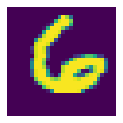

In [6]:
########################################
# データセットの読み込み
########################################

mnist = fetch_openml('mnist_784')
X = mnist["data"].values / 255
X_train, X_test = train_test_split(X, test_size=0.25, random_state=0)
X_train, X_test = jax.device_put(X_train), jax.device_put(X_test)
vector_to_image(X_train[0])

In [7]:
########################################
# モデルの作成 & 学習
########################################

# モデルの作成
AE = AutoEncoder()
params = AE.init(jax.random.PRNGKey(0), jnp.ones((1, 784)))["params"]

# SGDを定義
learning_rate = 0.001
tx = optax.adam(learning_rate)

# パラメータの管理
state = train_state.TrainState.create(apply_fn=AE.apply, params=params, tx=tx)

# エポック数
epoch_nums = 50
# バッチサイズ
batch_size = 256

# バッチ数
batch_length = X_train.shape[0] // batch_size

# nums_epoch回 学習する
for epoch_id in range(epoch_nums):
    
    # 訓練データのインデックスをシャッフル
    train_indices = jax.random.permutation(jax.random.PRNGKey(epoch_id+1), X_train.shape[0])
    # ミニバッチ学習で更新
    state = jax.lax.fori_loop(0, batch_length, train_batch, state)
    
    # 誤差の確認
    print(
        "訓練誤差:",
        '{:.3f}'.format(loss_function(state.params, X_train)),
        "汎化誤差:",
        '{:.3f}'.format(loss_function(state.params, X_test)),
        f"【 Epoch: {epoch_id} / {epoch_nums} 】"
    )

訓練誤差: 0.032 汎化誤差: 0.032 【 Epoch: 0 / 50 】
訓練誤差: 0.023 汎化誤差: 0.023 【 Epoch: 1 / 50 】
訓練誤差: 0.020 汎化誤差: 0.020 【 Epoch: 2 / 50 】
訓練誤差: 0.018 汎化誤差: 0.019 【 Epoch: 3 / 50 】
訓練誤差: 0.017 汎化誤差: 0.017 【 Epoch: 4 / 50 】
訓練誤差: 0.016 汎化誤差: 0.016 【 Epoch: 5 / 50 】
訓練誤差: 0.015 汎化誤差: 0.015 【 Epoch: 6 / 50 】
訓練誤差: 0.014 汎化誤差: 0.014 【 Epoch: 7 / 50 】
訓練誤差: 0.013 汎化誤差: 0.013 【 Epoch: 8 / 50 】
訓練誤差: 0.013 汎化誤差: 0.013 【 Epoch: 9 / 50 】
訓練誤差: 0.012 汎化誤差: 0.013 【 Epoch: 10 / 50 】
訓練誤差: 0.012 汎化誤差: 0.012 【 Epoch: 11 / 50 】
訓練誤差: 0.011 汎化誤差: 0.012 【 Epoch: 12 / 50 】
訓練誤差: 0.011 汎化誤差: 0.011 【 Epoch: 13 / 50 】
訓練誤差: 0.011 汎化誤差: 0.011 【 Epoch: 14 / 50 】
訓練誤差: 0.011 汎化誤差: 0.011 【 Epoch: 15 / 50 】
訓練誤差: 0.010 汎化誤差: 0.011 【 Epoch: 16 / 50 】
訓練誤差: 0.010 汎化誤差: 0.011 【 Epoch: 17 / 50 】
訓練誤差: 0.010 汎化誤差: 0.010 【 Epoch: 18 / 50 】
訓練誤差: 0.010 汎化誤差: 0.010 【 Epoch: 19 / 50 】
訓練誤差: 0.010 汎化誤差: 0.010 【 Epoch: 20 / 50 】
訓練誤差: 0.010 汎化誤差: 0.010 【 Epoch: 21 / 50 】
訓練誤差: 0.009 汎化誤差: 0.010 【 Epoch: 22 / 50 】
訓練誤差: 0.009 汎化誤差: 0.0

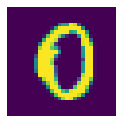

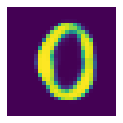

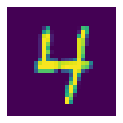

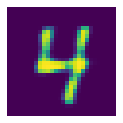

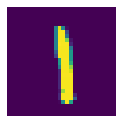

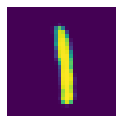

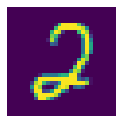

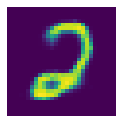

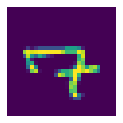

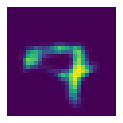

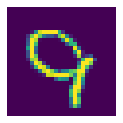

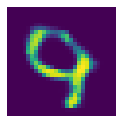

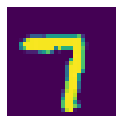

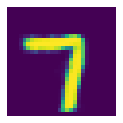

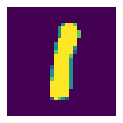

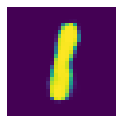

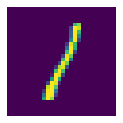

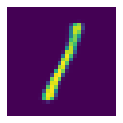

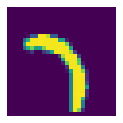

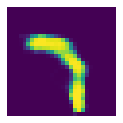

In [8]:
########################################
# テストデータで確認
########################################

PREDICT = AE.apply({"params": state.params}, X_test)
for i in range(10):
    vector_to_image(X_test[i]), vector_to_image(PREDICT[i])